# Dealing with Time Series

In this challenge the participants are going to try different concepts in analyzing time series. They will work only with information of wind speed denoted WSR and a number by it to denote hour of the day.
They are only allowed to plot their graphs with seaborn and matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Data Transformation

There are two different datasets, one is for the data(to be loaded header=None) the other is the header.

## 1. Load data with header

In [3]:
### load data which doesnt have a header
df=pd.read_csv('eighthr.data', header=None)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,1/1/1998,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0


In [4]:
### load data of the header
df_name=pd.read_csv('eighthr.names')
df_name.head(2)

,1,0 | two classes 1: ozone day,0: normal day
0,Date: ignore.,NaN,NaN
1,WSR0: continuous.,NaN,NaN


This step is not explicitly told to them so if they dont figure it out, you can tell them

In [5]:
### Removing useless info
df_name['1']=df_name['1'].apply(lambda x: x.split(':')[0])
df.columns=list(df_name['1'])+['ozone day']
df.head(3)

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,ozone day
0,1/1/1998,0.8,1.8,2.4,2.1,2,2.1,1.5,1.7,1.9,...,0.15,10.67,-1.56,5795,-12.1,17.9,10330,-55,0,0.0
1,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
2,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0


## 2. Transform data to timeseries datetime dataframe

Here, they are required to transform a data frame of 25 columns to one of 2 columns. They are actually building their time series from an even data

In [9]:
df_wind=pd.DataFrame()
dte=[]
wind=[]
for i in range(len(df)):
    for j in range(24):
        dte.append(str(df.Date.values[i])+' '+str(j)+':00')
        if df.iloc[i,1+j]!='?':
            wind.append(df.iloc[i,1+j]) 
        else:
            wind.append(0)
df_wind['date']=pd.to_datetime(dte,dayfirst=True)
df_wind['speed']=wind
df_wind.speed=df_wind.speed.astype(float)

In [10]:
df_wind.head(5)

,date,speed
0,1998-01-01 00:00:00,0.8
1,1998-01-01 01:00:00,1.8
2,1998-01-01 02:00:00,2.4
3,1998-01-01 03:00:00,2.1
4,1998-01-01 04:00:00,2.0


# Data Visualization

## 3. Plot of wind speed over the years

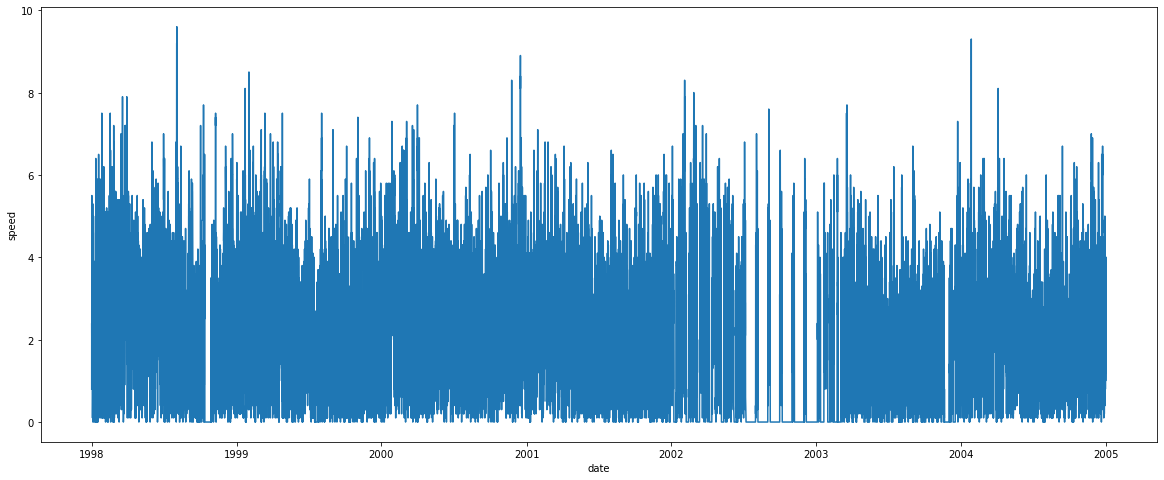

In [8]:
fig=plt.figure(figsize=(20,8))
sns.lineplot(x='date',y='speed',data=df_wind)
fig.show()

## 4. Flash Dashboard

They do not have to build a dash board, they have to play with the one provided to them. Follow the instruction below to run it. The idea in the dashboard is to see the seasonality in the data

Run 'python runserver.py' in the commandline 
Remember to Cd to the the location of the file

# Statistics

## 5. Augmented Dickey-Fuller test for stationality

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_wind.speed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -17.244782
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


The data has a unit root and is non-stationary, therefore is may be seasonal

## 6. Seasonality Test

The will be asked to choose a frequency. You need to guide them. 
The right frequency is 365 because when you look at the graph in their dashboard the pattern is repeated yearly so 365

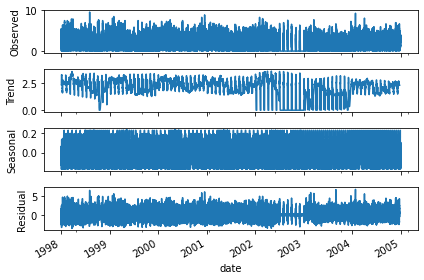

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
df=df_wind.set_index('date') ### remind them, if they do not figure this out
result = seasonal_decompose(df.speed.iloc[:], model='additive',freq=365) 
### frequency for the points so we compare points yearly
result.plot()
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

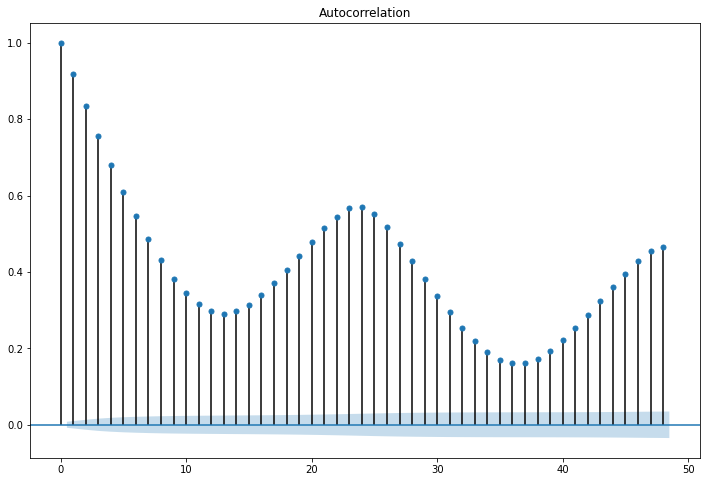

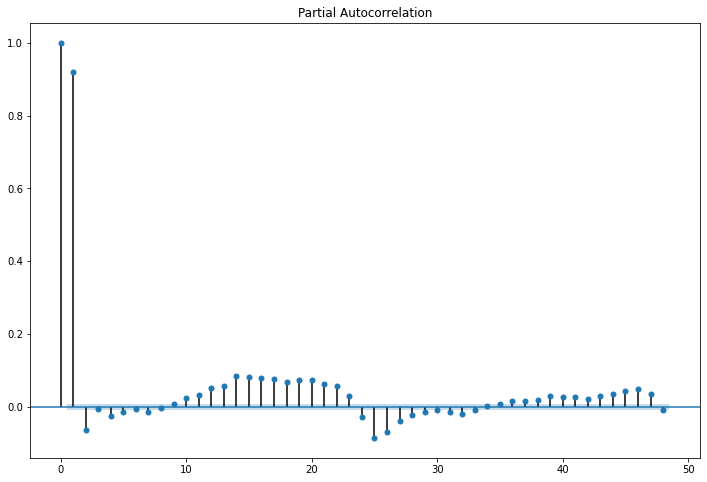

In [13]:
###Autocorrelation and Partial autocorelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df.speed.iloc[:])
plot_pacf(df.speed.iloc[:])
plt.show()

# Statistical Modelling

The order and seasonal order will be suggested to them.

In [58]:
import statsmodels.api as sms
mod=sms.tsa.statespace.SARIMAX(df.speed.iloc[:],order=(0,0,1),seasonal_order=(1,1,1,12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.3553      0.004    342.126      0.000       1.348       1.363
ar.S.L12      -0.0218      0.004     -5.413      0.000      -0.030      -0.014
ma.S.L12      -0.9216      0.002   -581.724      0.000      -0.925      -0.919
sigma2         0.4187      0.003    122.402      0.000       0.412       0.425


The interpretation of this plot lies in the Normal Q-Q which is the plot of the residual, It shows that the model is a good fit.

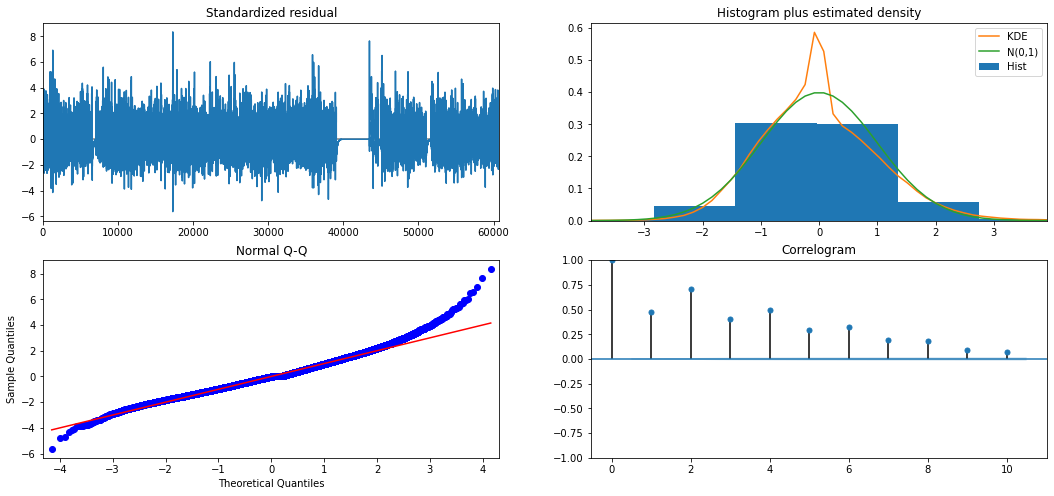

In [59]:
###### Visualize the error
results.plot_diagnostics(figsize=(18, 8))
plt.show()

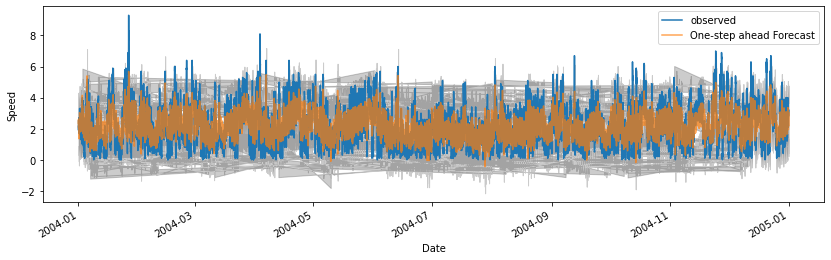

In [73]:
####### Predict the year 2004
pred = results.get_prediction(start=pd.to_datetime('01-01-2004',dayfirst=True), dynamic=False)
pred_ci = pred.conf_int()
ax = df.speed.iloc[:]['2004':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Speed')
plt.rcParams['figure.figsize'] = [12, 8]
plt.legend()
plt.show()

In their presentation they need to explain how they 
- created their time series from event data
- analyzed the data, stationality and seasonality test
- model and test the accuracy of the model